In [1]:
import numpy as np, pandas as pd
import sys
import time
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from timeVAE.vae_dense_model import VariationalAutoencoderDense as VAE_Dense
from timeVAE.vae_conv_model import VariationalAutoencoderConv as VAE_Conv
from timeVAE.vae_conv_I_model import VariationalAutoencoderConvInterpretable as TimeVAE
from timeVAE import utils

2024-03-19 16:51:46.654515: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-19 16:51:46.654544: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-19 16:51:46.655574: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-19 16:51:46.661386: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-19 16:51:47.429694: W tensorflow/compiler/tf2

In [2]:
data_noaa = pd.read_csv('../data/NOAA_10yr_std_filtered.csv', index_col='time', usecols=['time','G.E_el_I', 'G.sky.T'])

In [3]:
print(data_noaa.shape)

(87601, 2)


In [4]:
print(data_noaa)

              G.sky.T  G.E_el_I
time                           
0.0          0.305147  0.033333
3600.0       0.283088  0.233333
7200.0       0.275735  1.000000
10800.0      0.273897  0.444444
14400.0      0.268382  1.000000
...               ...       ...
315345600.0  0.395221  0.999982
315349200.0  0.384191  0.999982
315352800.0  0.378676  0.999982
315356400.0  0.373162  0.999982
315360000.0  0.373162  0.999982

[87601 rows x 2 columns]


In [5]:
def create_rolling_windows(df, window_size, stride):
    windows = []
    for start in range(0, len(df) - window_size + 1, stride):
        end = start + window_size
        window = df.iloc[start:end]
        windows.append(window)
    return np.array(windows)

windowed_data = create_rolling_windows(data_noaa, int(24*365), int(24))
print(windowed_data.shape)

(3286, 8760, 2)


In [7]:
import tensorflow as tf

# Hide GPU from visible devices
tf.config.set_visible_devices([], 'GPU')
tf.config.get_visible_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]

In [8]:
seq_len = windowed_data.shape[1]
feat_dim = windowed_data.shape[2]

latent_dim = 20
hidden_layer_sizes = [64,128,64]

model = TimeVAE(seq_len=seq_len, feat_dim=feat_dim, latent_dim=latent_dim, hidden_layer_sizes=hidden_layer_sizes)

2024-03-19 16:58:24.262447: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1227801600 exceeds 10% of free system memory.
2024-03-19 16:58:24.545539: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1227801600 exceeds 10% of free system memory.
2024-03-19 16:58:24.730596: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1227801600 exceeds 10% of free system memory.


In [9]:
model.compile(optimizer=Adam(learning_rate=0.001))

In [10]:
from sklearn.model_selection import train_test_split

X_train, X_valid = train_test_split(windowed_data, test_size=0.2)

print(X_train.shape, X_valid.shape)

(2628, 8760, 2) (658, 8760, 2)


In [11]:
early_stop = EarlyStopping(monitor='loss', patience=10, verbose=1)
reduce_lr  = ReduceLROnPlateau(monitor='loss', factor=0.5, patience=5, verbose=1)

history = model.fit(X_train,
                   epochs = 100,
                   batch_size = 16,
                   callbacks = [early_stop, reduce_lr],
                   verbose = 1)


Epoch 1/100


2024-03-19 16:58:29.062533: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1227801600 exceeds 10% of free system memory.
2024-03-19 16:58:29.173993: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1227801600 exceeds 10% of free system memory.
2024-03-19 16:58:30.994356: I external/local_xla/xla/service/service.cc:168] XLA service 0x7f83291c1b50 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2024-03-19 16:58:30.994382: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
2024-03-19 16:58:31.002158: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1710867511.068561   17242 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
2024-03-19 16:58:31.070644: E external/lo

  1/165 [..............................] - ETA: 11:20 - loss: 535408.5625 - reconstruction_loss: 178468.9375 - kl_loss: 1.7211

2024-03-19 16:58:33.441446: E external/local_xla/xla/stream_executor/stream_executor_internal.h:177] SetPriority unimplemented for this stream.
2024-03-19 16:58:33.451303: E external/local_xla/xla/stream_executor/stream_executor_internal.h:177] SetPriority unimplemented for this stream.


  5/165 [..............................] - ETA: 5:11 - loss: 432079.4813 - reconstruction_loss: 122802.8906 - kl_loss: 1946.8269

2024-03-19 16:58:41.204512: E external/local_xla/xla/stream_executor/stream_executor_internal.h:177] SetPriority unimplemented for this stream.


165/165 [==============================] - 322s 2s/step - loss: 141913.5513 - reconstruction_loss: 32361.3184 - kl_loss: 793.0181 - lr: 0.0010
Epoch 2/100
165/165 [==============================] - 321s 2s/step - loss: 81185.0228 - reconstruction_loss: 25408.1113 - kl_loss: 472.8573 - lr: 0.0010
Epoch 3/100
165/165 [==============================] - 321s 2s/step - loss: 65917.0184 - reconstruction_loss: 21648.8457 - kl_loss: 452.2378 - lr: 0.0010
Epoch 4/100
118/165 [====================>.........] - ETA: 1:31 - loss: 65279.4283 - reconstruction_loss: 21718.6309 - kl_loss: 705.7571

2024-03-19 17:18:22.793969: E external/local_xla/xla/stream_executor/stream_executor_internal.h:177] SetPriority unimplemented for this stream.


165/165 [==============================] - 321s 2s/step - loss: 65434.7459 - reconstruction_loss: 21592.7324 - kl_loss: 668.4858 - lr: 0.0010
Epoch 5/100
165/165 [==============================] - 322s 2s/step - loss: 65003.5872 - reconstruction_loss: 21426.6484 - kl_loss: 573.2485 - lr: 0.0010
Epoch 6/100
165/165 [==============================] - 321s 2s/step - loss: 65733.1984 - reconstruction_loss: 21511.2559 - kl_loss: 755.9081 - lr: 0.0010
Epoch 7/100
165/165 [==============================] - 322s 2s/step - loss: 64312.7134 - reconstruction_loss: 21243.2305 - kl_loss: 431.7466 - lr: 0.0010
Epoch 8/100
165/165 [==============================] - 322s 2s/step - loss: 64232.0375 - reconstruction_loss: 21166.0059 - kl_loss: 409.6377 - lr: 0.0010
Epoch 9/100
165/165 [==============================] - 322s 2s/step - loss: 64043.7139 - reconstruction_loss: 21090.4746 - kl_loss: 439.7755 - lr: 0.0010
Epoch 10/100
165/165 [==============================] - 321s 2s/step - loss: 64250.2786 

Epoch 57/100
165/165 [==============================] - 322s 2s/step - loss: 47146.8681 - reconstruction_loss: 15526.5166 - kl_loss: 1032.8334 - lr: 0.0010
Epoch 58/100
165/165 [==============================] - 322s 2s/step - loss: 45957.0272 - reconstruction_loss: 15115.8770 - kl_loss: 1055.1257 - lr: 0.0010
Epoch 59/100
165/165 [==============================] - 322s 2s/step - loss: 44694.6494 - reconstruction_loss: 14752.3496 - kl_loss: 1070.1183 - lr: 0.0010
Epoch 60/100
165/165 [==============================] - 322s 2s/step - loss: 43000.5029 - reconstruction_loss: 14186.3867 - kl_loss: 1088.4615 - lr: 0.0010
Epoch 61/100
165/165 [==============================] - 322s 2s/step - loss: 41356.0379 - reconstruction_loss: 13679.3535 - kl_loss: 1106.5529 - lr: 0.0010
Epoch 62/100
165/165 [==============================] - 322s 2s/step - loss: 40139.5148 - reconstruction_loss: 13212.9102 - kl_loss: 1130.6371 - lr: 0.0010
Epoch 63/100
165/165 [==============================] - 322s 2s/

In [12]:
model.save('../model/', file_pref='20ld_16b_elsky')

In [17]:
loss = pd.DataFrame(history.history)
print(loss)
loss.to_csv('../model/hist/20ld_16b_elsky_hist.csv')

            loss  reconstruction_loss      kl_loss     lr
0   97877.023438         32361.318359   793.018066  0.001
1   76697.171875         25408.111328   472.857300  0.001
2   65398.750000         21648.845703   452.237823  0.001
3   65446.671875         21592.732422   668.485840  0.001
4   64853.167969         21426.648438   573.248535  0.001
..           ...                  ...          ...    ...
95   8993.254883          2595.315674  1207.307129  0.001
96   8686.416992          2494.145020  1203.984131  0.001
97   8218.583008          2337.115234  1207.237549  0.001
98   7801.230957          2201.081299  1197.988037  0.001
99   7330.049805          2046.591675  1190.276123  0.001

[100 rows x 4 columns]


In [3]:
model = TimeVAE.load('../model/', file_pref='20ld_16b')

2024-03-18 11:52:50.734249: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 6572 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1080, pci bus id: 0000:03:00.0, compute capability: 6.1
2024-03-18 11:53:00.202921: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1227801600 exceeds 10% of free system memory.


In [7]:
print(model)

None


In [12]:
print(X_train.shape)

(2628, 8760, 2)


In [18]:
x_decoded = model.predict(X_valid)#model.predict(np.random.normal(loc=0, scale=1, size=(376,8760,2)))

21/21 [==============================] - 6s 208ms/step


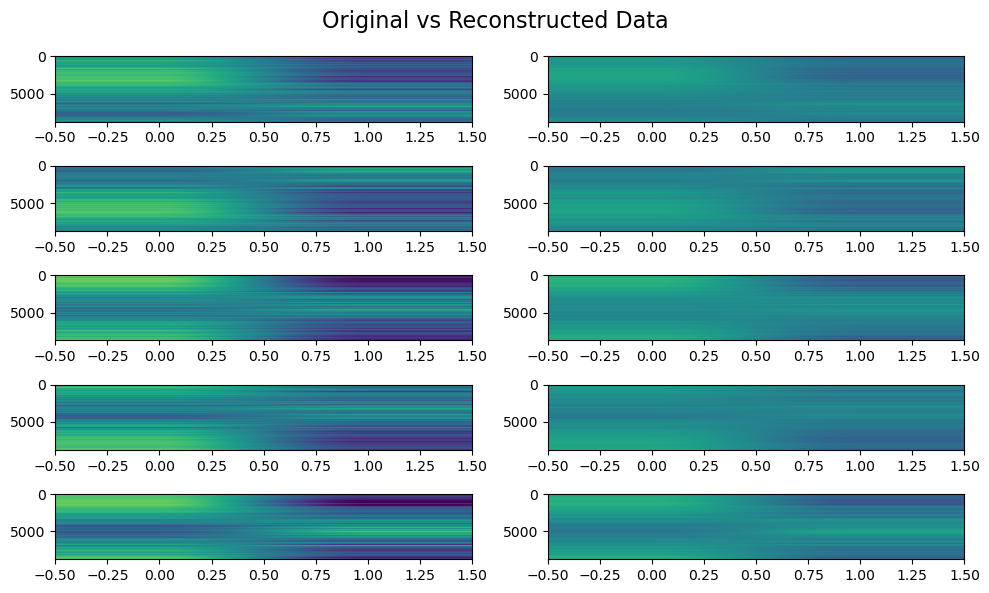

In [19]:
utils.draw_orig_and_post_pred_sample(X_valid, x_decoded, n=5)

4/4 [==============================] - 1s 156ms/step
(100, 8760, 2)


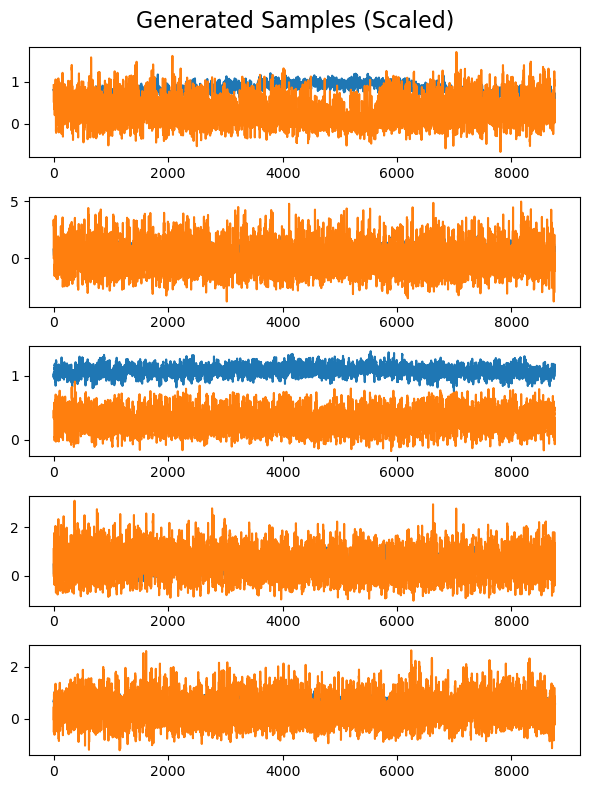

In [22]:
num_samples = 100
samples = model.get_prior_samples(num_samples=num_samples)
print(samples.shape)

utils.plot_samples(samples,n=5)

In [16]:
np.save('../data/VAEsamples20ld16b.npy', samples)

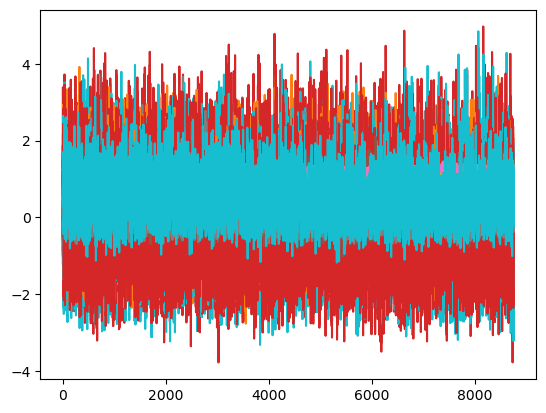

In [23]:
import matplotlib.pyplot as plt
for sample in samples:
    plt.plot(sample)

In [34]:
samples.shape

(100, 8760, 2)

In [ ]:
data

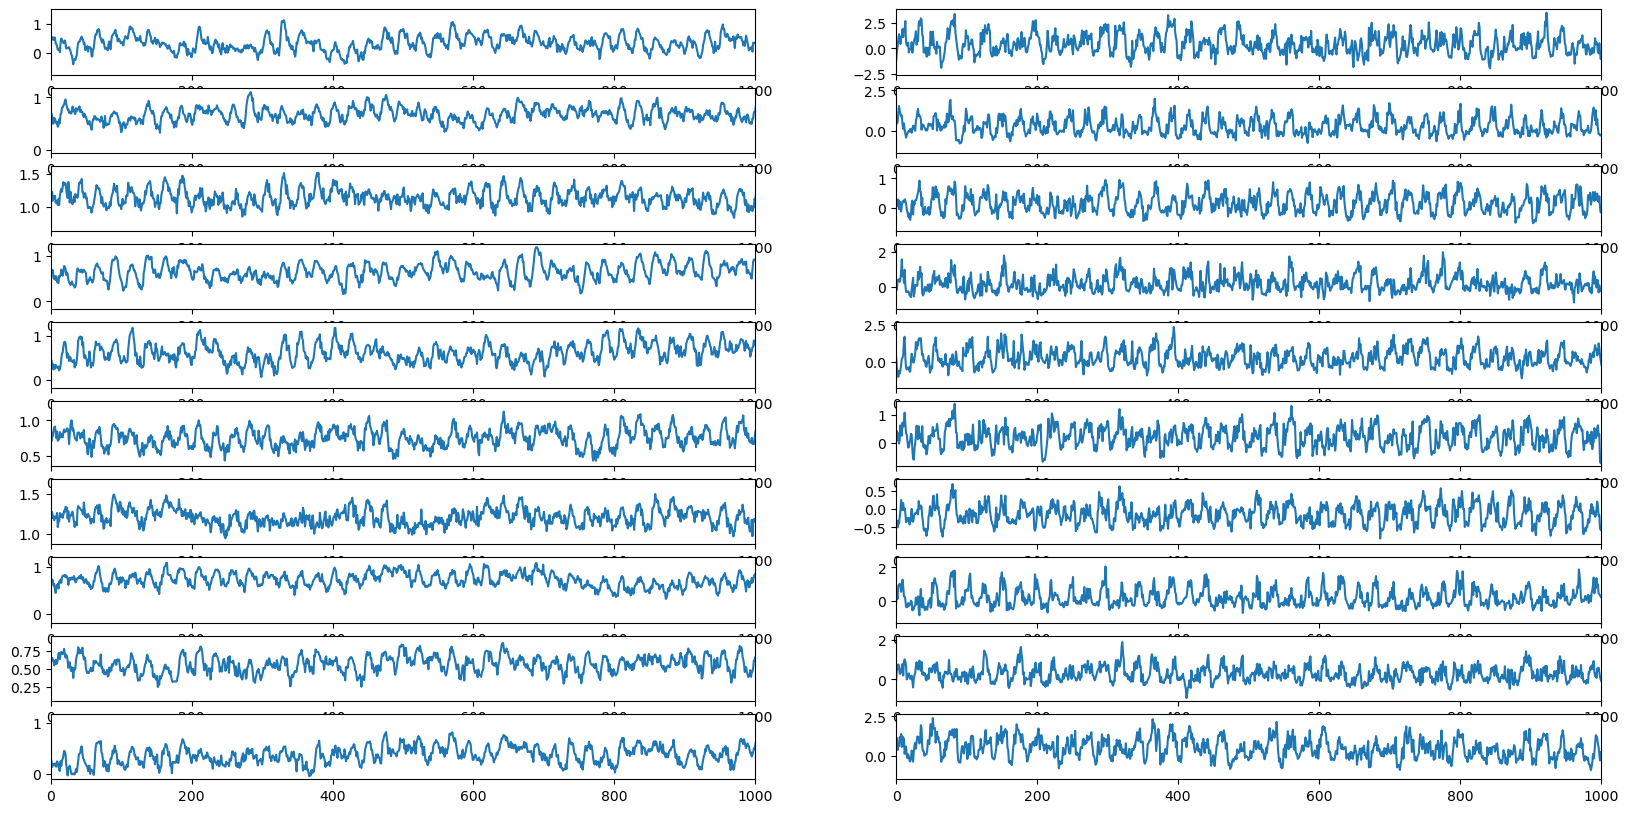

In [24]:
fig, ax = plt.subplots(10, 2, figsize=(20,10))
for i in range(10):
    ax[i,0].plot(samples[i,:,0])
    ax[i,1].plot(samples[i,:,1])
    ax[i,0].set_xlim(0,1000)
    ax[i,1].set_xlim(0,1000)

In [22]:
X_train.shape

(376, 8760, 2)

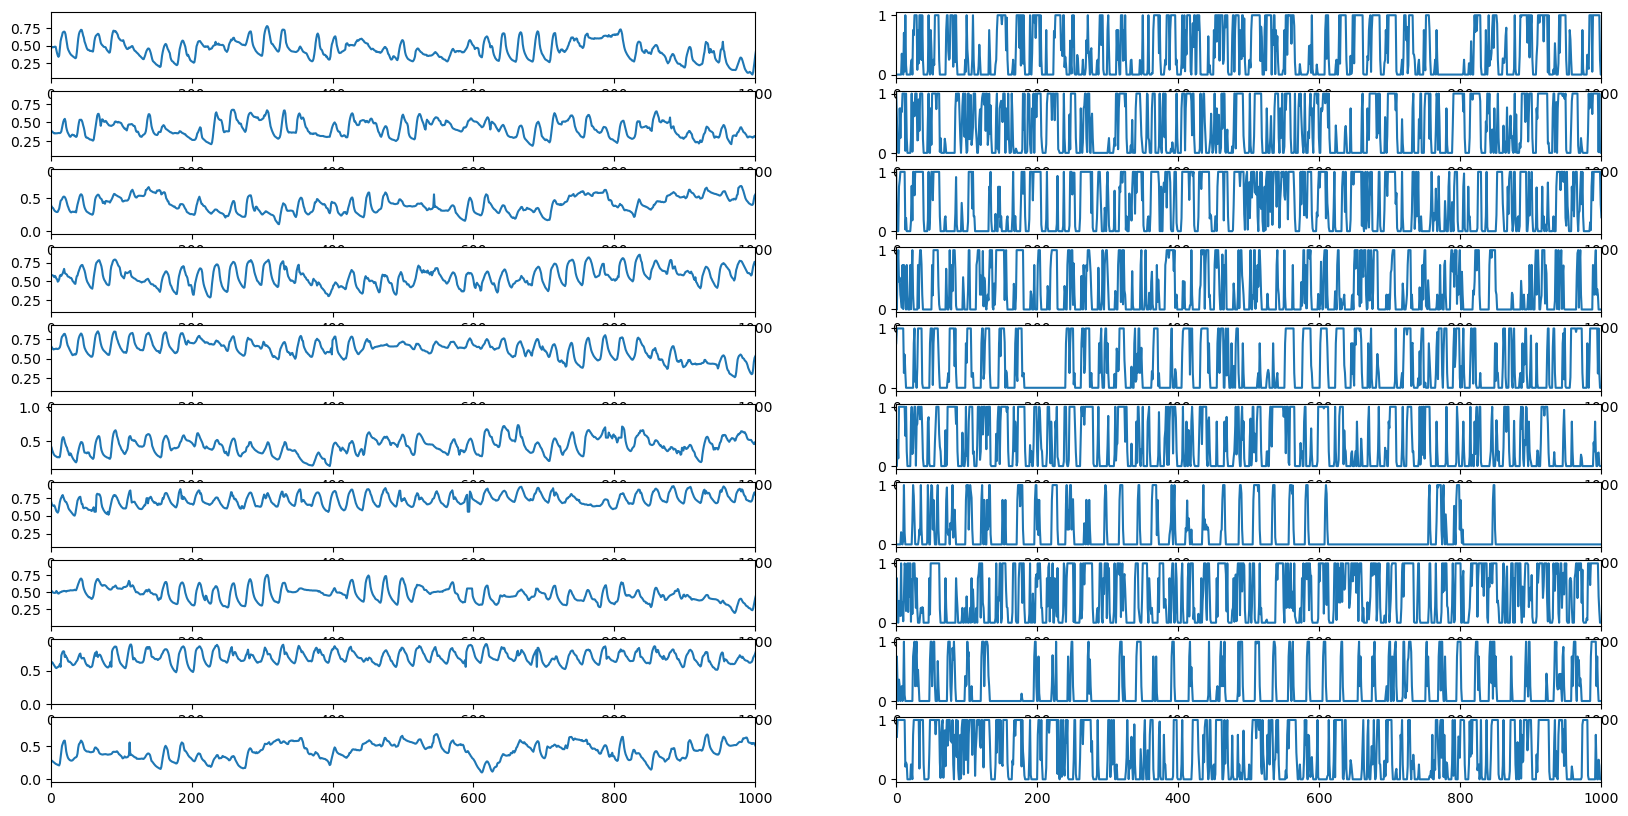

In [25]:
fig, ax = plt.subplots(10, 2, figsize=(20,10))
for i in range(10):
    ax[i,0].plot(X_train[i,:,0])
    ax[i,1].plot(X_train[i,:,1])
    ax[i,0].set_xlim(0,1000)
    ax[i,1].set_xlim(0,1000)

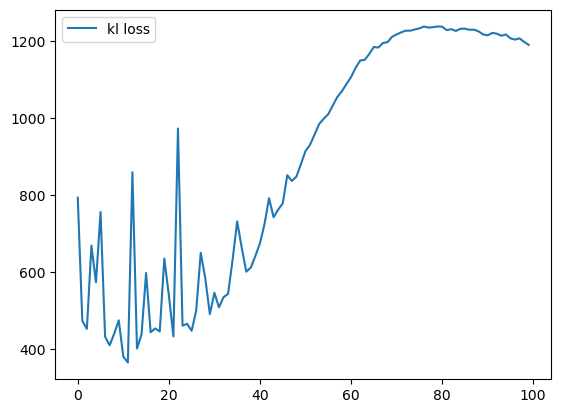

In [40]:
#plt.plot(history.history['loss'], label='loss')
#plt.plot(history.history['reconstruction_loss'], label='reconstruction loss')
plt.plot(history.history['kl_loss'], label='kl loss')
plt.legend()

plt.savefig('../imgs/curve_of_vae_kl_elsky.png')